<img src="https://raw.githubusercontent.com/UCLAMAEThreads/FluidDynTools.jl/main/notebook/logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **Introduction to Fluid Dynamics**
<hr />

# Vortex shedding
Up to now, we have been content to construct flow fields from basic elements
(freestream, body motion, vortices) without considering how these elements
came about. In particular, the vorticity often emerges from viscous processes happening
at the body surface (see [the Rayleigh problem](3.0-RayleighProblem.ipynb)).

In an inviscid model of a flow, we do not explicitly represent the viscous processes,
but we can model those processes by noting that their overall effect is often to
cause boundary layers along the body surface to separate at salient edges
on the body, such as the trailing edge of a wing. We account for this in the
model with the **Kutta condition**, which states that vorticity should be
produced at an edge in such measure that it makes the velocity *finite* at the edge.

In [1]:
using FluidDynTools

In [2]:
using FluidDynTools.PotentialFlow.Bodies
import FluidDynTools.PotentialFlow: Polygon, RigidBodyMotion

In [3]:
using Plots

## Set up the body
For this problem, we will use a flat plate, achieved by creating a two-point
polygon. We will place the plate at 20 degrees angle of attack,
pointing to the left (so we rotate it clockwise, by -20π/180 radians)

In [4]:
c = 1.0
p = Polygon([-0.5c,0.5c],[0.0,0.0])
Zr = 0.0+0.0im
α = -20*π/180
b = ConformalBody(p,Zr,α)

Body generated by: Schwarz-Christoffel map of unit circle to exterior of polygon with 2 vertices

  centroid at 0.0 + 0.0im
  angle -0.3491


As in the last notebook, we will set up the grid and transform each point to the $\zeta$ plane.

In [5]:
xlim=(-2,2)
ylim=(-1,1)
xg = range(xlim...,length=201)
yg = range(ylim...,length=51)
zg = [x + im*y for y in yg, x in xg]
ζg = inverse_conftransform(zg,b);

To get an appreciation for what the flow looks like if we do not
shed vorticity, let's plot the flow past this plate. If you
look closely at the trailing edge (the edge on the right side),
you can see the streamlines are not coming smoothly off the edge, but
instead at an angle

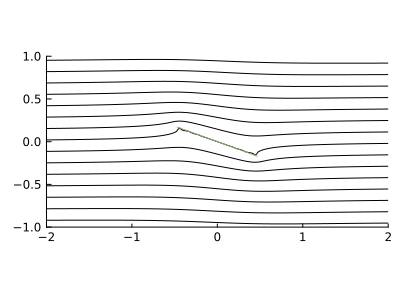

In [6]:
t = 0.0
motion = RigidBodyMotion(0.0, 0.0)
Winf = 1.0 + 0.0im
fs = Freestreams.Freestream(conj(Winf))
sys = (fs,)
sys = inverse_conftransform(sys,b)

clear_images!(b)
enforce_no_flow_through!(b, motion, sys, t)

ps = streamlines(xg,yg,ζg,(b,sys),levels=range(-2,2,length=31),xlim=xlim,ylim=ylim)
plot!(ps,b)

We will fix this behavior by producing vorticity at the trailing edge.
Instead of this reference frame, we will solve the problem in a
reference frame in which the *body* moves from right to left.

First, we need to set up some functions. The first one will be used
to calculate the velocity of every vortex

In [7]:
function compute_ẋ!(ẋ, x, t)
    body, ambient_sys = x
    motion = ẋ[1]
    # update the instantaneous motion of the body with the current motion
    motion.ċ, motion.c̈, motion.α̇, motion.α̈ = motion.kin(t)

    enforce_no_flow_through!(body, motion, ambient_sys, t)

    # Zero the velocity
    reset_velocity!(ẋ, x)

    # Compute the self-induced velocity of the system
    self_induce_velocity!(ẋ, x, t)

    # Modify the velocity so that it provides the rate of change in the circle plane.
    transform_velocity!(ẋ, ẋ, x, body)
end

compute_ẋ! (generic function with 1 method)

Once we have advected all the vortex elements, we release new blobs from the designated
edges of the body. The function below adds new blobs to the set with the correct strength to
enforce edge conditions.

In [8]:
function shed_new_vorticity!(blobs, edge1, edge2, body, motion, t, spcrit1 = 0.0, spcrit2 = 0.0)
    # edge1 and edge2 specify the indices of edge points on the body

    ϕ = 1/3 # fractional distance from the edge point to the previous blob

    # Location edges in physical plane
    zedge1 = body.zs[edge1]
    zedge2 = body.zs[edge2]

    # positions of previously-released blobs, transformed to physical plane
    zblob1 = conftransform(blobs[end-1].z,body)
    zblob2 = conftransform(blobs[end].z,body)

    # positions of new blobs in physical plane
    z1 = ϕ*zblob1 + (1-ϕ)*zedge1
    z2 = ϕ*zblob2 + (1-ϕ)*zedge2

    # positions of new blobs in circle plane
    ζ1 = inverse_conftransform(z1,body)
    ζ2 = inverse_conftransform(z2,body)

    # new blobs, with unit strength for now
    blob1 = Vortex.Blob(ζ1, 1.0, δ)
    blob2 = Vortex.Blob(ζ2, 1.0, δ)

    enforce_no_flow_through!(body, motion, blobs, t)

    # Determine the strengths of the new blobs
    Γ1, Γ2 = Bodies.vorticity_flux(body, edge1, edge2, (body,blobs), [blob1], [blob2], t, spcrit1, spcrit2);

    # Add the new blobs to the list
    push!(blobs, Vortex.Blob(ζ1, Γ1, blobs[1].δ), Vortex.Blob(ζ2, Γ2, blobs[1].δ))

end

shed_new_vorticity! (generic function with 3 methods)

## Set the problem parameters and initialize it

In [9]:
Δt = 5e-3
b = ConformalBody(p,Zr,α)
Żr = -1.0 + 0.0im
motion = RigidBodyMotion(Żr,0.0)


# critical edge suction parameters
spcrit1 = Inf # leading edge. Make this Inf if you want to suppress vortex shedding from the leading edge.
spcrit2 = 0 # trailing edge

kLE, kTE = 1, 2

# Nothing to change below this line

# blob radius
δ = 0.02

# locations of edges in physical plane
zedge1, zedge2 = b.zs[[kLE,kTE]]

# Vector to add to these edges. This determines the initial placement of the
# first vortex elements relative to the edges.
# Δz₀ = -3*im*Δt*exp(-im*b.α)
Δz₀ = [-3*Δt*exp(im*b.α),3*Δt*exp(im*b.α)]


# locations of initial blobs in circle plane
ζblob = inverse_conftransform(Δz₀ .+ [zedge1, zedge2],b)

# create the initial two blobs, for now with unit strength
blobs = Vortex.Blob.(ζblob, 1.0, δ)

enforce_no_flow_through!(b, motion, (), 0.0)
sys = (b,)

# This determines the circulations that enforce the edge conditions
Γ1, Γ2 = Bodies.vorticity_flux(b, kLE, kTE, sys, [blobs[1]], [blobs[2]], 0, spcrit1, spcrit2);

# Now create the blobs with the correct circulations
blobs = Vortex.Blob.(ζblob, [Γ1, Γ2], δ)

# This creates the image blobs, so that no-penetration condition is enforced
enforce_no_flow_through!(b, motion, blobs, 0.0)

# Set up the initial system
ambient_sys = blobs

t = 0.0
sys = (b, ambient_sys)
sys₊ = deepcopy(sys) # Used for storage during time-marching
nothing

## Initialize the problem arrays

In [10]:
ẋs = (motion, allocate_velocity(ambient_sys))
time = Float64[]
imp = ComplexF64[]
blob_z = conftransform(ambient_sys,b)
track = [deepcopy((b,blob_z))]
push!(imp,Elements.impulse((b,blob_z)))
tsamp = 0.25 # Rate at which to save system data in `track` array
nothing

## Solve the problem

In [11]:
tf = 0.5
for tloc in 0:Δt:tf
    b_now, ambient_ω_ζ = sys

    resize!(sys₊[2], length(sys[2]))
    TimeMarching.forward_euler!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)

    global sys₊, sys = sys, sys₊

    global t += Δt

    shed_new_vorticity!(sys[2], kLE, kTE, sys[1], ẋs[1], t, spcrit1, spcrit2)

    # save stuff
    push!(time,t)
    b_now, ambient_ω_ζ = deepcopy(sys)
    global blob_z = conftransform(ambient_ω_ζ,b_now)

    if abs(mod(t,tsamp))<1e-8 || abs(mod(t,tsamp)-tsamp)<1e-8
        push!(track,deepcopy((b_now,blob_z)))
    end

    enforce_no_flow_through!(b_now, motion, ambient_ω_ζ, t)
    push!(imp,Elements.impulse((b_now,blob_z)))

end
b_now, ambient_ω_ζ = sys
blob_z = conftransform(ambient_ω_ζ,b_now);

### Plot the vortices

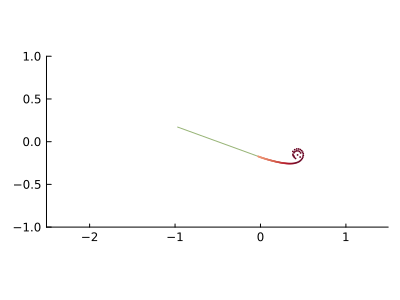

In [12]:
xlim = (-2-time[end],2-time[end])
ylim = (-1,1)
ps = plot(track[end],legend=false,markerstrokewidth=0,color=cgrad(:RdBu,rev=true),clim=(-0.025/(2π),0.025/(2π)),markersize=1,ratio=1,xlim=xlim,ylim=ylim) #

### Plot the streamlines

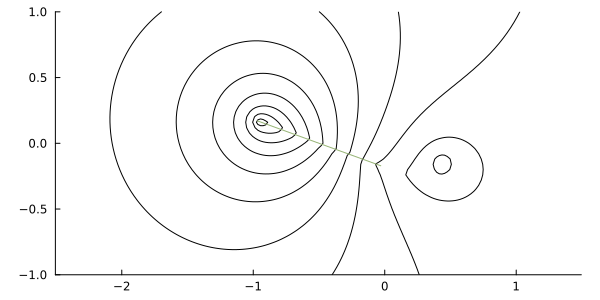

In [13]:
xg = range(xlim...,length=201)
yg = range(ylim...,length=51)
zg = [x + im*y for y in yg, x in xg]
ζg = inverse_conftransform(zg,b)
ps = streamlines(xg,yg,ζg,(b,sys),levels=range(-1,1,length=31),xlim=xlim,ylim=ylim)
plot!(ps,b,size=(600,300))

### Plot the force
Here, we are approximately computing

$$f = -\rho dP/dt$$

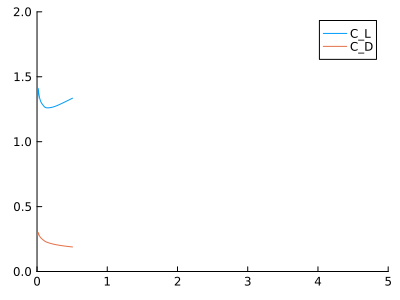

In [14]:
fhist = -diff(imp)/Δt
plot(time,2*imag.(fhist),label="C_L",xlim=(0,5),ylim=(0,2),legend=true)
plot!(time,2*real.(fhist),label="C_D")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*